In [25]:
from collections import OrderedDict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_distances

from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
from utils.preprocessor import Stopwords_preprocessor
from utils.markdown import beir_metrics_to_markdown_table
from IPython.display import Markdown

# from rank_bm25 import BM25Okapi as BM25
from transformers import logging, AutoTokenizer
from beir.datasets.data_loader import GenericDataLoader
from beir.retrieval.evaluation import EvaluateRetrieval

In [3]:
import pathlib
import torch
from torch import nn

In [4]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [5]:
# from beir import util
# dataset =  'trec-covid' # "nfcorpus" 
# url = "https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/{}.zip".format(dataset)
# data_path = util.download_and_unzip(url, 'data')

In [1488]:
corpus_name = 'scifact'
# corpus_name = 'trec-covid'
# corpus_name = 'nfcorpus'

corpus, queries, qrels = GenericDataLoader(f'data/{corpus_name}').load(split="test")
corpus_text = [v['text'] for k,v in corpus.items()]

  0%|          | 0/5183 [00:00<?, ?it/s]

In [1724]:
def tokenize(x):
    return tokenizer.convert_ids_to_tokens(tokenizer.encode(x, add_special_tokens=False))

vectorizer = TfidfVectorizer(tokenizer=tokenize, vocabulary=tokenizer.vocab)
%time vectorizer.fit(corpus_text)

/home/adam/miniconda3/envs/lima/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/adam/miniconda3/envs/lima/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


CPU times: user 7.35 s, sys: 0 ns, total: 7.35 s
Wall time: 7.35 s


TfidfVectorizer(tokenizer=<function tokenize at 0x7f6f5744f600>,
                vocabulary={'!': 999, '"': 1000, '#': 1001, '##!': 29612,
                            '##"': 29613, '###': 29614, '##$': 29615,
                            '##%': 29616, '##&': 29617, "##'": 29618,
                            '##(': 29619, '##)': 29620, '##*': 29621,
                            '##+': 29622, '##,': 29623, '##-': 29624,
                            '##.': 29625, '##/': 29626, '##0': 2692,
                            '##00': 8889, '##01': 24096, '##0s': 16223,
                            '##1': 2487, '##10': 10790, '##100': 18613,
                            '##11': 14526, '##12': 12521, '##13': 17134,
                            '##14': 16932, '##15': 16068, ...})

In [1490]:
# # test
# text_sample = corpus[list(corpus.keys())[0]]['text']
# res = mean_rotary_discrepency(text_sample)
# res.shape

In [1491]:
def mean_vector(text):
    ids = tokenizer.encode(text, add_special_tokens=False)
    if len(ids) == 0:
        return np.zeros(word_reprs.shape[1])
    return word_reprs[ids].mean(axis=0)

def sum_vector(text):
    ids = tokenizer.encode(text, add_special_tokens=False)
    return word_reprs[ids].sum(axis=0)


def idf_mean_vector(text):
  ids = tokenizer.encode(text, add_special_tokens=False)
  # return (vectorizer.idf_[ids] @ word_reprs[ids]) / (len(ids) + 1e-8) # 這個比較慢，可能跟 contiguous 有關
  return np.einsum('ld,l', word_reprs[ids], vectorizer.idf_[ids]) / (len(ids) + 1e-8)

weight norms, min: 1.5416946411132812, max: 110.11259460449219
min norms: ['[unused688]', '[unused357]', '[unused636]', '[unused478]', '[unused894]', '[unused410]', '[unused330]', '[unused32]', '[unused96]', '##“']
max norms: ['work', 'opened', 'population', '–', '%', 'released', 'signed', 'announced', 'years', 'there']
bias norms, min: -3.814605474472046, max: 8.040963172912598
min norms: ['##ה', '##aceous', 'ᵍ', 'laszlo', 'representations', 'chung', 'meyrick', '##ᵘ', '[unused908]', 'cbn']
max norms: ['in', 'a', 'he', 'i', 'gods', 'to', 'the', 'and', '.', ',']


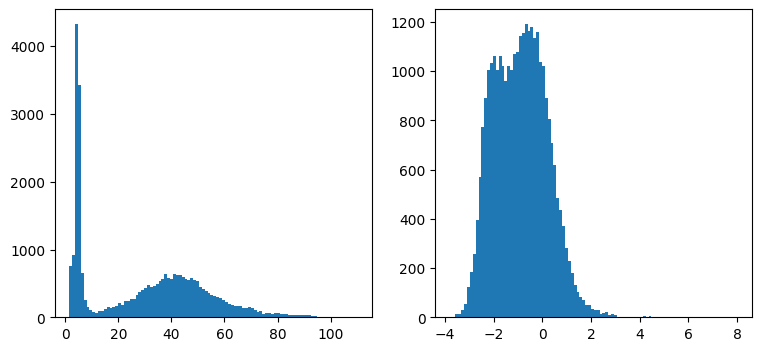

In [1840]:
folder_path = pathlib.Path('data/limanet/')

subpath = '20240618.13:45:57' #lima6
# subpath = '20240618.17:32:36' #lima6
# subpath = '20240618.18:45:47' #lima5_no_hippo, randn init embedding
# subpath = '20240618.19:30:10' # lima5_no_hippo_xavier, lr0.01
# subpath = '20240618.19:51:52' # lima5_no_hippo_xavier, lr0.001
# subpath = '20240619.02:40:48' # lima6_randnInit, lr0.001
subpath = '20240619.04:22:03' # lima6, l2weight 0.01, lr 5e-4
subpath = '20240619.10:06:59' # lima5_no_hippo_xavier, l2weight 1e-4, lr 0.001
# subpath = '20240619.13:19:54' # lima6, dynamic_scale
subpath = '20240620.01:43:06' # lima6, dynamic scale
subpath = '20240621.10:13:15' # lima7
subpath = '20240621.10:17:31' # lima7_gru
# subpath = '20240621.13:18:59' # lima7_gru
subpath = '20240621.16:38:47' # lima7_gru_randInit
subpath = '20240622.02:23:27' # lima7_gru, Cross_entropy_l2_embedding(model.model, l2_squared_weight=1e-3), lr0.005
subpath = '20240622.02:24:23' # lima7_gru_randInit, Cross_entropy_l2_embedding(model.model, l2_squared_weight=1e-3), lr0.005
subpath = '20240622.03:41:40' # lima7_gru_mixInit, Cross_entropy_l2_embedding(model.model, l2_squared_weight=1e-3), lr0.005
subpath = '20240622.05:16:52' # 4
subpath = '20240622.06:42:05' # 5
# subpath = '20240622.06:50:40' # 6
subpath = '20240622.12:38:37' # 4 lima7_mixInit, higher lr, mixInit, AdamW
# subpath = '20240622.16:50:54' # 5 lima8, AdamW
subpath = '20240622.17:20:54' # 6 lima8, scaled init
subpath = '20240623.14:51:34' # 4 lima8, sampled_softmax_cross_entropy, lr0.02
subpath = '20240623.15:36:29' # 5 lima8, sampled_softmax_cross_entropy, lr0.005
# subpath = '20240623.15:45:02' # 6 lima8, sampled_softmax_cross_entropy, lr0.005, randInit
subpath = '20240623.17:25:38' # 7 lima8, lr0.02
subpath = '20240623.18:32:21' # 4 lima8_perToken, lr0.01
subpath = '20240624.06:20:31' # 5 lima8_perToken, lr0.005
subpath = '20240624.07:04:03' # 4 lima8_perToken, lr0.01, xavier
subpath = '20240624.09:58:53' # 6
subpath = '20240624.12:08:14' # 4 ssm_ce_with_bias
# subpath = '20240624.14:02:39' # 5 lima8, ssm_ce_with_bias
subpath = '20240624.16:42:08' # 7 lima8, wiki
# subpath = '20240624.20:32:15' # 6 lima8_perToken, wiki
subpath = '20240625.10:17:52' # 4 train wiki on '20240624.12:08:14'batch-25000
subpath = '20240625.11:39:15' # 5 train wiki on '20240624.12:08:14'batch-20000
subpath = '20240626.09:08:18' # 4 train wiki on '20240624.12:08:14'batch-25000
subpath = '20240626.09:43:48' # 5 train wiki on '20240624.12:08:14'batch-20000

batch_num = 10000
RNN = torch.load(folder_path/subpath/f'batch_{batch_num}-model.pt', map_location='cpu')
# model = torch.load(folder_path/subpath/f'last_batch-model.pt', map_location='cpu')

epoch_num = 1
RNN = torch.load(folder_path/subpath/f'epoch_{epoch_num}-model.pt', map_location='cpu')

RNN.eval()

model = RNN.model
word_reprs_complex = model.predictor.all_word_embeddings()
word_reprs = torch.concat([word_reprs_complex.real, word_reprs_complex.imag], dim=-1).detach().numpy()
word_reprs_complex = word_reprs_complex.detach().numpy()

# angle_reprs = model.angle_embedding.weight.detach().numpy()


vectors = word_reprs
# vectors = angle_reprs

_, (ax_w, ax_b) = plt.subplots(1, 2, figsize=[9, 4])

# weight stats
norms = np.linalg.norm(vectors, axis=1)
indices = norms.argsort()
print(f"weight norms, min: {norms.min()}, max: {norms.max()}")
print("min norms:", tokenizer.convert_ids_to_tokens(indices[:10]))
print("max norms:", tokenizer.convert_ids_to_tokens(indices[-10:]))
_ = ax_w.hist(norms, bins=100)

# bias stats
biases = RNN.bias.detach()
indices = biases.argsort()
print(f"bias norms, min: {biases.min()}, max: {biases.max()}")
print("min norms:", tokenizer.convert_ids_to_tokens(indices[:10]))
print("max norms:", tokenizer.convert_ids_to_tokens(indices[-10:]))
if hasattr(model.predictor, 'base_vec'):
  print(f"base vec norm: {model.predictor.base_vec.norm()}")
_ = ax_b.hist(biases, bins=100)

In [1841]:
# inputs = tokenizer('I love you.', return_tensors='pt', add_special_tokens=False)
# histories = [his.expand(4, *[-1]*(len(his.shape)-1)) for his in model.initial_states()['histories']]
# output, next_histories = model.forward(inputs['input_ids'][0], 1, histories)

In [1842]:
method = idf_mean_vector
method = mean_vector
# method = sum_vector

part = 'text'
# part = 'title'

%time text_vec_dict = OrderedDict({k: method(v[part]) for k, v in corpus.items()})
%time query_vec_dict = OrderedDict({k: method(v) for k, v in queries.items()})
text_vecs = np.stack(list(text_vec_dict.values()))

CPU times: user 6.45 s, sys: 424 ms, total: 6.87 s
Wall time: 6.87 s
CPU times: user 50 ms, sys: 0 ns, total: 50 ms
Wall time: 49.9 ms


In [1843]:
metric = 'euclidean'
metric = 'cosine'


def score(query_vector, metric=metric):
    return (1/pairwise_distances(query_vector[None, :], text_vecs, metric=metric))[0]

%time results = {qid: dict(zip(text_vec_dict.keys(), score(query_vector).tolist())) \
            for qid, query_vector in query_vec_dict.items()}

metrics = EvaluateRetrieval.evaluate(qrels, results, [1, 3, 5, 10, 100, 1000])

flatten_metrics = {k: v for metric_type in metrics for k, v in metric_type.items()}
metric_names, metric_values = zip(*flatten_metrics.items())
print(*metric_names, sep='\t')
print(*metric_values, sep='\t')
print()

md = beir_metrics_to_markdown_table(*metrics)
Markdown(md)

CPU times: user 26.6 s, sys: 1min 36s, total: 2min 3s
Wall time: 2.47 s
NDCG@1	NDCG@3	NDCG@5	NDCG@10	NDCG@100	NDCG@1000	MAP@1	MAP@3	MAP@5	MAP@10	MAP@100	MAP@1000	Recall@1	Recall@3	Recall@5	Recall@10	Recall@100	Recall@1000	P@1	P@3	P@5	P@10	P@100	P@1000
0.05667	0.06835	0.06979	0.07919	0.11019	0.14457	0.05667	0.065	0.06583	0.06981	0.07533	0.07622	0.05667	0.07667	0.08	0.10778	0.26028	0.545	0.05667	0.02667	0.01667	0.01133	0.00277	0.00062



||NDCG|MAP|Recall|P|
|-|-|-|-|-|
|@1|0.0567|0.0567|0.0567|0.0567|
|@3|0.0683|0.0650|0.0767|0.0267|
|@5|0.0698|0.0658|0.0800|0.0167|
|@10|0.0792|0.0698|0.1078|0.0113|
|@100|0.1102|0.0753|0.2603|0.0028|
|@1000|0.1446|0.0762|0.5450|0.0006|

In [1737]:
inputs = tokenizer('I love you.', return_tensors='pt', add_special_tokens=False)
histories = [his.expand(4, *[-1]*(len(his.shape)-1)) for his in model.initial_states()['histories']]
output, next_histories = model.forward(inputs['input_ids'][0], 1, histories)

KeyError: 'histories'

In [491]:
# for i in range(len(model.limas)):
#     lima_shape = model.limas[i].lima_shape
#     print(lima_shape)
#     print(f'{i}: {lima_shape.min()}, {lima_shape.max()}')

In [16]:
model.predictor.rotary_denom

Parameter containing:
tensor(0.6350, requires_grad=True)

In [17]:
# # write first 10 questions and top 10 answer to file

# samples = list(results.items())[:10]
# for q_num, score_dict in samples:
#     with open(f'question_{q_num}.txt', 'w') as f:
#         f.write(f'{queries[q_num]}\n\n')
#         tokens = tokenizer.convert_ids_to_tokens(tokenizer(queries[q_num], add_special_tokens=False)['input_ids'])
#         f.write(f'{tokens}\n\n')
        
#         text_ids, text_scores = zip(*score_dict.items())
#         text_scores = np.array(text_scores)
#         top_10_idx = np.argsort(text_scores)[:-10:-1]

#         for idx in top_10_idx:
#             f.write(f'{corpus[text_ids[idx]]}\n\n')

In [18]:
# #test: 看每個字往時間方向逆向轉一個 t 後，附近的字為何。理論來說會是跟這個字無關的字 (text independent)，因為這個旋轉抵銷了時間旋轉

# inverse_metric_theta = - 1/model.predictor.rotary_denom**(model.predictor.dimension_nums/model.predictor.dim)
# inverse_pos_rotation = torch.complex(inverse_metric_theta.cos(), inverse_metric_theta.sin())
# least_effective_position_of_the_word = model.predictor.all_word_embeddings() * inverse_pos_rotation
# least_effective_position_of_the_word = torch.concat([least_effective_position_of_the_word.real, least_effective_position_of_the_word.imag], dim=-1).detach().numpy()

# least_effective_position_of_the_word.shape

# %time d = pairwise_distances(word_reprs, least_effective_position_of_the_word, metric='euclidean') # metric='cosine'

# %time pair = d.argsort(axis=1)[:, :10]

# for input_id in tokenizer.encode(text_sample):
#     print(f'{tokenizer.convert_ids_to_tokens(input_id)}: {tokenizer.convert_ids_to_tokens(pair[input_id])}')